##### CNN 이미지 분류 모델
    - 이미지 데이터셋 준비
        * torchvision 내장 데이터셋 CIFAR10
    - 이미지 분류 모델
        * 커스텀 CNN 구현

[1] 모듈 로딩 및 데이터 준비<hr> 

In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10    # torchvision 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor # torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader     # 데이터셋 관련 모듈 로딩

In [2]:
# 데이터로딩
DIR_PATH='../../../Localdata/'

# Pytorch의 Dataset 형태 로딩
cifarDS=CIFAR10(DIR_PATH,
                train=True,
                download=True,
                transform=ToTensor())

Files already downloaded and verified


In [3]:
type(cifarDS)

torchvision.datasets.cifar.CIFAR10

In [4]:
# Dataset의 속성 확인
print(f'cifarDS.classes : {cifarDS.classes}')

print(f'cifarDS.class_to_idx : {cifarDS.class_to_idx}')

print(f'cifarDS.data.shape : {cifarDS.data.shape}')

print(f'len(cifarDS.targets) : {len(cifarDS.targets)}')


cifarDS.classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarDS.class_to_idx : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
cifarDS.data.shape : (50000, 32, 32, 3)
len(cifarDS.targets) : 50000


[2] 데이터 로더 <hr>
- 학습 시 배치크기만큼 데이터와 라벨/타겟을 로딩

In [5]:
BATCH_SIZE=50

cifar10DL=DataLoader(cifarDS)

In [6]:
for data, target in cifar10DL:
    print(target)
    data=data.numpy().squeeze()
    print(data.shape)
    print(data.T.shape)
    break

tensor([6])
(3, 32, 32)
(32, 32, 3)


tensor([6])
torch.Size([1, 3, 32, 32])


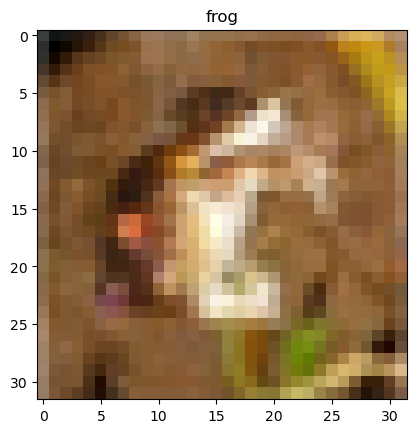

In [7]:
# [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(target)
    print(data.shape)
    data1=data.squeeze()
    plt.imshow(data1.transpose(0,2))
    plt.title(cifarDS.classes[target.item()])
    break

[3] 커스텀 모델 설계 및 정의 <hr>
- 모델　목적 : 이미지 분류 모델
- 학습　방법 : 지도학습 > 분류 > 다중분류 (10개)
- 클래스이름 : ImageMCF
- 클래스구조 : 특징추출부분 => CNN + 학습부분 FC
- 부모클래스 : nn.Module

In [8]:
class ImageMCF(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        # 특징 추출
        self.in_layer=nn.Conv2d(3, 10, 3)
        self.p_layer=nn.MaxPool2d(2, stride=2)

        # 학습 관련 층
        self.hd_layer=nn.Linear(10*15*15, 50)
        self.out_layer=nn.Linear(50, 10)
    
    
    # 전방향/순방향 학습 메서드
    def forward(self, input):
        # 이미지 특징 맵 추출
        output=self.in_layer(input)
        print(f'[output 1 ] {output.shape}')

        output=F.relu(output)
        print(f'[output 2 ] {output.shape}')

        output=self.p_layer(output)
        print(f'[output 3 ] {output.shape}')

        # 4D => 2D (샘플수, 피쳐수)
        output=output.view(output.shape[0], -1)
        print(f'[output 4 ] {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[output 5 ] {output.shape}')

        output=self.out_layer(output)
        print(f'[output 6 ] {output.shape}')

        return output

In [19]:
class ImageMCF2(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        # 특징 추출 층
        self.cnn_layer1=nn.Sequential(
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            )

        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10, 30, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            )
        
        # 학습 관련 층
        self.hd_layer=nn.Linear(30*6*6, 50)
        self.out_layer=nn.Linear(50, 10)
    
    
    # 전방향/순방향 학습 메서드
    def forward(self, input):
        # 이미지 특징 맵 추출
        output=self.cnn_layer1(input)
        print(f'[cnn_layer1 output ] {output.shape}')

        output=self.cnn_layer2(output)
        print(f'[cnn_layer2 output ] {output.shape}')

        # 4D => 2D (샘플수, 피쳐수)
        output=output.view(output.shape[0], -1)
        print(f'[view output] {output.shape}')

        output=F.relu(self.hd_layer(output))
        print(f'[hd_layer output ] {output.shape}')

        output=self.out_layer(output)
        print(f'[out_layer output ] {output.shape}')

        return output

In [20]:
# [테스트] 모델 인스턴스 생성
m=ImageMCF2()

In [21]:
# 모델 정보 출력 패키지 설치
#%pip install torchinfo

In [22]:
from torchinfo import summary
summary(m)

Layer (type:depth-idx)                   Param #
ImageMCF2                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,730
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Linear: 1-3                            54,050
├─Linear: 1-4                            510
Total params: 57,570
Trainable params: 57,570
Non-trainable params: 0

In [23]:
# [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(f'[target] => {target}')
    print(data.shape)
    pre=m(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer1 output ] torch.Size([1, 10, 15, 15])
[cnn_layer2 output ] torch.Size([1, 30, 6, 6])
[view output] torch.Size([1, 1080])
[hd_layer output ] torch.Size([1, 50])
[out_layer output ] torch.Size([1, 10])
pre => tensor([9])


In [18]:
# 모델 파라미터 확인
for name, param in m.named_parameters():
    print(f'>>[{name}]==========\n{param.shape}')

>>[cnn_layer1.0.weight]==========
torch.Size([10, 3, 3, 3])
>>[cnn_layer1.0.bias]==========
torch.Size([10])
>>[cnn_layer2.0.weight]==========
torch.Size([30, 10, 3, 3])
>>[cnn_layer2.0.bias]==========
torch.Size([30])
>>[hd_layer.weight]==========
torch.Size([50, 1080])
>>[hd_layer.bias]==========
torch.Size([50])
>>[out_layer.weight]==========
torch.Size([10, 50])
>>[out_layer.bias]==========
torch.Size([10])
